In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import shap

C:\Users\bimod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
df = pd.read_csv("compas-scores-two-years.csv")

In [70]:
df['total_juv_count'] = df.get('juv_fel_count', 0) + df.get('juv_misd_count', 0) + df.get('juv_other_count', 0)
df['priors_per_age'] = df['priors_count'] / (df['age'] + 1)
df['age_squared'] = df['age'] ** 2

In [71]:
columns = [
    'age', 'sex', 'race', 'priors_count', 'c_charge_degree', 'score_text',
    'total_juv_count', 'priors_per_age', 'age_squared', 'two_year_recid'
]
df = df[columns].dropna()

In [72]:
le = LabelEncoder()
for col in ['sex', 'race', 'c_charge_degree', 'score_text']:
    df[col] = le.fit_transform(df[col])

In [73]:
df['is_young'] = (df['age'] < 25).astype(int)
df['is_old'] = (df['age'] > 45).astype(int)
df['priors_bin'] = pd.cut(df['priors_count'], bins=[-1, 0, 2, 5, 100], labels=[0, 1, 2, 3])
df['priors_bin'] = df['priors_bin'].astype(int)

X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

In [88]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SMOTE ===
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# === SPLIT TRAIN TEST ===
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [89]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

stack_model = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('cat', cat)],
    final_estimator=LogisticRegression(),
    passthrough=True,
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001F3AB5EDAD0>)],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   passthrough=True)

In [90]:
y_proba = stack_model.predict_proba(X_test)[:, 1]

# === THRESHOLD OPTIMIZATION ===
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_thresh = thresholds[np.argmax(f1_scores)]

y_pred = (y_proba >= best_thresh).astype(int)

In [91]:
# Print Results
print("=== EVALUASI MODEL STACKING TUNED ===")
print("Threshold terbaik:", round(best_thresh, 3))
print("Accuracy :", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("F1 Score :", round(f1_score(y_test, y_pred) * 100, 2), "%")
print("ROC AUC  :", round(roc_auc_score(y_test, y_proba) * 100, 2), "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

=== EVALUASI MODEL STACKING TUNED ===
Threshold terbaik: 0.428
Accuracy : 72.13 %
F1 Score : 73.72 %
ROC AUC  : 78.15 %
Confusion Matrix:
 [[524 269]
 [173 620]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.66      0.70       793
           1       0.70      0.78      0.74       793

    accuracy                           0.72      1586
   macro avg       0.72      0.72      0.72      1586
weighted avg       0.72      0.72      0.72      1586



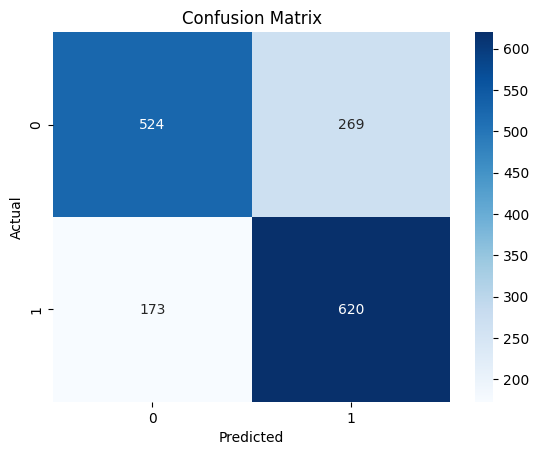

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

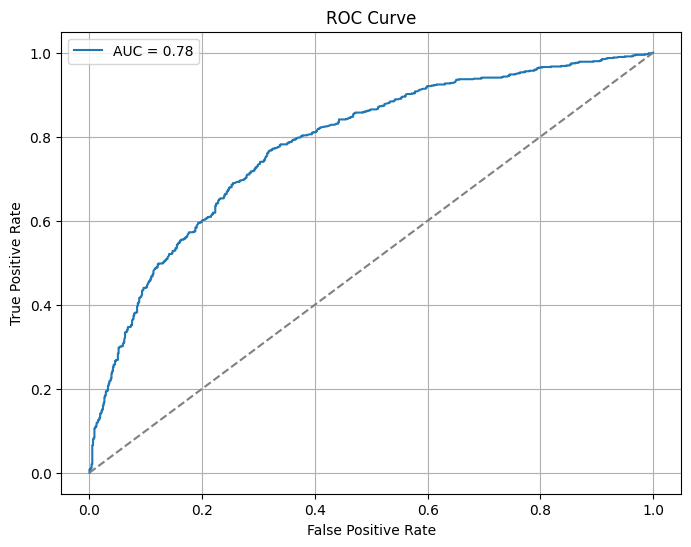

In [93]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


=== SHAP FEATURE IMPORTANCE (CatBoost) ===


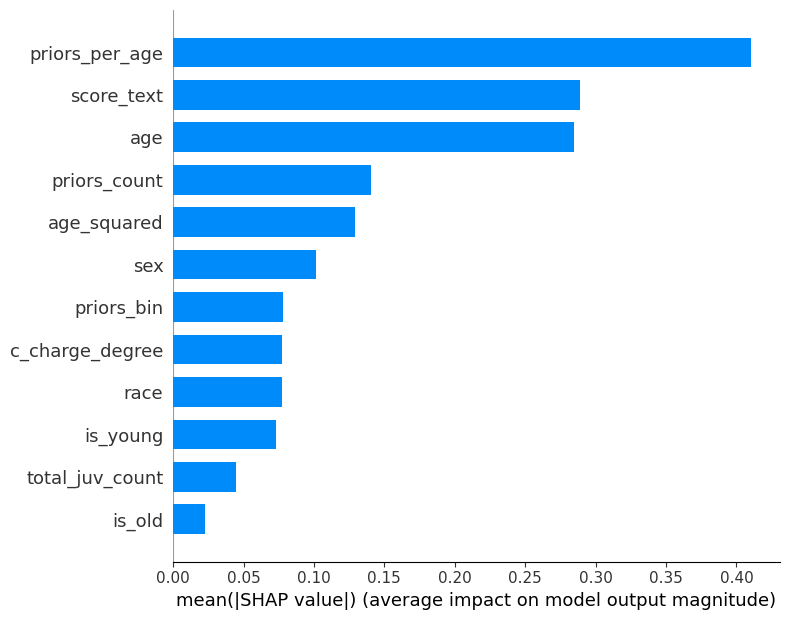

In [79]:
# === FIT CATBOOST SENDIRI UNTUK SHAP ===
cat_shap = CatBoostClassifier(verbose=0, random_state=42)
cat_shap.fit(X_train, y_train)

# === SHAP ANALYSIS ===
print("\n=== SHAP FEATURE IMPORTANCE (CatBoost) ===")
explainer = shap.TreeExplainer(cat_shap)
shap_values = explainer.shap_values(X_test)

# Tampilkan SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


**Penjelasan Persamaan Matematika**
  Berikut penjelasan untuk setiap metrik evaluasi yang digunakan:

  a. Akurasi (Accuracy)
  
  TP + TN / TP + TN + FP + FN

   - TP (True Positive): Prediksi benar kelas positif.

   - TN (True Negative): Prediksi benar kelas negatif.

   - FP (False Positive): Prediksi salah kelas positif.

   - FN (False Negative): Prediksi salah kelas negatif.

   - Interpretasi: Persentase prediksi yang benar dari total prediksi.

  b. Presisi (Precision)
  
  TP / TP + FP

  - Interpretasi: Proporsi prediksi positif yang benar. Tinggi jika sedikit false positive.

  c. Recall (Sensitivity)

  TP / TP + FN

  - Interpretasi: Proporsi instance positif yang terdeteksi. Tinggi jika sedikit false negative.

  d. F1 Score

  2 x Presisi x Recall / Presisi + Recall

  - Interpretasi: Rata-rata harmonik presisi dan recall. Berguna jika kelas tidak seimbang.

  e. AUC-ROC (Area Under Curve - Receiver Operating Characteristic)
  - ROC Curve: Plot True Positive Rate (Recall) vs False Positive Rate (FPR = FP / (FP + TN)).

  - AUC: Luas di bawah kurva ROC. Nilai 1 = sempurna, 0.5 = acak.

  - Interpretasi: Kemampuan model membedakan kelas positif dan negatif.

  f. ROC Curve
  Dibuat dengan memvariasikan threshold klasifikasi dan menghitung TPR vs FPR.